In [2]:
! pip install --quiet git-remote-codecommit


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import boto3
import sagemaker
import time
from time import strftime

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto3.client("sagemaker")
region = boto_session.region_name
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account = sagemaker_session.boto_session.client("sts").get_caller_identity()["Account"]

prefix = 'sagemaker-intel-dvc'

print(f"account: {account}")
print(f"bucket: {bucket}")
print(f"region: {region}")
print(f"role: {role}")

account: 523843493491
bucket: sagemaker-us-west-2-523843493491
region: us-west-2
role: arn:aws:iam::523843493491:role/service-role/AmazonSageMaker-ExecutionRole-20220211T001925


In [4]:
from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role

In [5]:
dvc_repo_url = "codecommit::us-west-2://sagemaker-intel"
dvc_branch = "processed-dataset"

In [6]:
# script_processor = ScriptProcessor(
#     command=['python'],
#     image_uri='523843493491.dkr.ecr.us-west-2.amazonaws.com/emlov2-private-repo-yaseen:aws-dlc',
#     role=get_execution_role(),
#     instance_type='ml.t3.medium',
#     instance_count=1,
#     base_job_name='preprocess-intel-dataset',
#     env={
#         "DVC_REPO_URL": dvc_repo_url,
#         "DVC_BRANCH": dvc_branch,
#         "GIT_USER": "Mohammed Yaseen",
#         "GIT_EMAIL": "47.yaseen@gmail.com"
#     }
# )

pytorch_processor = PyTorchProcessor(
    framework_version='1.13',
    image_uri='523843493491.dkr.ecr.us-west-2.amazonaws.com/emlov2-private-repo-yaseen:aws-dlc',
    role=get_execution_role(),
    instance_type='ml.t3.medium',
    instance_count=1,
    base_job_name='preprocess-intel-dataset',
    env={
        "DVC_REPO_URL": dvc_repo_url,
        "DVC_BRANCH": dvc_branch,
        "GIT_USER": "Mohammed Yaseen",
        "GIT_EMAIL": "47.yaseen@gmail.com"
    }
)

In [7]:
input_dataset = "s3://sagemaker-us-west-2-523843493491/intel-image-classification.zip"

In [8]:
# script_processor.run(
#     code='../preprocess.py',
#     inputs=[
#         ProcessingInput(
#             input_name='data',
#             source=input_dataset,
#             destination='/opt/ml/processing/input'
#         )
#     ],
#     # outputs=[
#     #     ProcessingOutput(output_name='data_structured', source='/opt/ml/processing/tmp/data_structured', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
#     #     ProcessingOutput(output_name='train', source='/opt/ml/processing/output/train', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
#     #     ProcessingOutput(output_name='validation', source='/opt/ml/processing/output/val', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
#     #     ProcessingOutput(output_name='test', source='/opt/ml/processing/output/test', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
#     #     ProcessingOutput(output_name='logs', source='/opt/ml/processing/logs', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}')
#     # ]
# )

pytorch_processor.run(
    code='preprocess.py',
    source_dir='utils',
    inputs=[
        ProcessingInput(
            input_name='data',
            source=input_dataset,
            destination='/opt/ml/processing/input'
        )
    ],
)


Job Name:  preprocess-intel-dataset-2023-01-17-14-29-39-321
Inputs:  [{'InputName': 'data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-523843493491/intel-image-classification.zip', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-523843493491/preprocess-intel-dataset-2023-01-17-14-29-39-321/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'entrypoint', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-523843493491/preprocess-intel-dataset-2023-01-17-14-29-39-321/source/runproc.sh', 'LocalPath': '/opt/ml/processing/input/entrypoint', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File'

In [9]:
%pwd

'/root/emlov2-session-12'

In [10]:
! aws s3 cp s3://sagemaker-us-west-2-523843493491/intel-image-classification.zip .

download: s3://sagemaker-us-west-2-523843493491/intel-image-classification.zip to ./intel-image-classification.zip


In [11]:
from torchvision.datasets.utils import extract_archive

from pathlib import Path

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import torchvision.transforms as T
from PIL import Image

In [13]:
%pwd

'/root/emlov2-session-12'

In [14]:
dataset_zip = Path("/root/emlov2-session-12/intel-image-classification.zip")
dataset_extracted = Path("/root/emlov2-session-12/")

In [15]:
extract_archive(
    from_path=dataset_zip,
    to_path=dataset_extracted
)

PosixPath('/root/emlov2-session-12')

In [16]:
dataset_train = list((dataset_extracted / "seg_train" / "seg_train").glob("*/*.jpg"))
labels_train = [x.parent.stem for x in dataset_train]

dataset_test = list((dataset_extracted / "seg_test" / "seg_test").glob("*/*.jpg"))
labels_test = [x.parent.stem for x in dataset_test]

In [17]:
import numpy as np

In [18]:
from collections import Counter

In [19]:
print("Train counts: ", Counter(labels_train))
print("Test counts: ", Counter(labels_test))

Train counts:  Counter({'mountain': 2512, 'glacier': 2404, 'street': 2382, 'sea': 2274, 'forest': 2271, 'buildings': 2191})
Test counts:  Counter({'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501, 'forest': 474, 'buildings': 437})


In [20]:
# ! pip install --quiet scikit-learn

In [21]:
# from sklearn.model_selection import train_test_split

In [22]:
dataset_train[0], labels_train[0]

(PosixPath('/root/emlov2-session-12/seg_train/seg_train/buildings/15920.jpg'),
 'buildings')

In [23]:
dataset_train[0].name

'15920.jpg'

In [24]:
# d_train, d_test = train_test_split(dataset_full, stratify=labels)

In [25]:
Counter(x.parent.stem for x in dataset_train)

Counter({'buildings': 2191,
         'sea': 2274,
         'forest': 2271,
         'mountain': 2512,
         'street': 2382,
         'glacier': 2404})

In [26]:
Counter(x.parent.stem for x in dataset_test)

Counter({'buildings': 437,
         'sea': 510,
         'forest': 474,
         'mountain': 525,
         'street': 501,
         'glacier': 553})

In [27]:
git_path = Path("/root/emlov2-session-12/example-git")
for path in ['train', 'test']:
        output_dir = git_path / "dataset" / path
        output_dir.mkdir(parents=True, exist_ok=True)

In [28]:
# import shutil

In [29]:
# def write_dataset(image_paths, output_dir):
#     for img_path in image_paths:
#         Path(output_dir / img_path.parent.stem).mkdir(parents=True, exist_ok=True)
#         shutil.copyfile(img_path, output_dir / img_path.parent.stem / img_path.name)

In [30]:
def write_dataset(image_paths, output_dir):
    transform = T.Resize(size=(224, 224))
    for img_path in image_paths:
        Path(output_dir / img_path.parent.stem).mkdir(parents=True, exist_ok=True)
        im = Image.open(img_path)
        im = transform(im)
        # shutil.copyfile(img_path, output_dir / img_path.parent.stem / img_path.name)
        im.save(output_dir / img_path.parent.stem / img_path.name)

In [31]:
write_dataset(dataset_train, git_path / "dataset" / "train")
write_dataset(dataset_test, git_path / "dataset" / "test")

In [32]:
from torchvision.datasets import ImageFolder

In [33]:
img_dset = ImageFolder(git_path / "dataset" / "train")

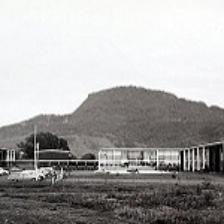

In [34]:
img_dset[0][0]

In [35]:
img_dset = ImageFolder(git_path / "dataset" / "test")

In [36]:
img_dset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']